# Process for generating clone heatmaps with cell type annotation for sample b19

In [1]:
library(ggplot2)
library(ggrepel)
library(plyr)
library(dplyr)
library(Seurat)
library(tidyr) 
library(DescTools)
library(pheatmap)


setwd("./out/")
dat_name <- "b19_tdmr_CA_aut"

Warning message:
"package 'plyr' was built under R version 4.0.5"

Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching SeuratObject

Warning message:
"package 'tidyr' was built under R version 4.0.5"


In [20]:
# Set color palettes to use later on

# regions
reg_colors <- c("tel" = "#7fc97f", #green
                "dien" = "#beaed4", #purple
                "mes" = "#fdc086", #orange
                "rhom" = "#ffff99", #yellow
                "global" = "#386cb0" #blue
                )

# major cell types
mct_colors <- c("Neurons" = "#80b1d3", #blue
               "Radial glia" = "#6342b7", #purple
               "Oligodendroglia" = "#fccde5", #pink
               "Immune cells" = "#1c7239", #green
               "Ependymal cells" = "#bbad0d", #yellow
               "Erythrocytes" = "#fb8072", #red
               "Epithelial cells" = "#d9d9d9", #grey
               "Endothelial cells" = "#fdb462" #orange
              )

# for scars / genes
tol21rainbow= c("#771155", "#AA4488", "#CC99BB", "#114477", "#4477AA", "#77AADD", "#117777", "#44AAAA", "#77CCCC", "#117744", "#44AA77", "#88CCAA", "#777711", "#AAAA44", "#DDDD77", "#774411", "#AA7744", "#DDAA77", "#771122", "#AA4455", "#DD7788", "#525252", "#969696", "#252525", "#C6DBEF", "#FC9272", "#C7E9C0", "#DBDBDB", "#FDEE02", "#FFAB00", "#4D4DBF", "#BF4DBF", "#999999")


In [4]:
# Read in clonal information based on results from pariwise-merging of target genes.
# These files are the output of the function merge_target_pairs() in the clone calling process.

scars_1 <- read.delim("final_combclones_b19_tdmr_CA_aut_actb1_actb2_allinfo_per_cell_scar_80.txt", stringsAsFactors = F, sep = ',')
scars_2 <- read.delim("final_combclones_b19_tdmr_CA_aut_actb1_rpl39_with_singlescarcells_allinfo_per_cell_scar.txt", stringsAsFactors = F, sep = ',')
scars_3 <- read.delim("final_combclones_b19_tdmr_CA_aut_actb1_cfl1_with_singlescarcells_allinfo_per_cell_scar.txt", stringsAsFactors = F, sep = ',')
scars_4 <- read.delim("final_combclones_b19_tdmr_CA_aut_actb1_cirbpb_allinfo_per_cell_scar_80.txt", stringsAsFactors = F, sep = ',')
scars_5 <- read.delim("final_combclones_b19_tdmr_CA_aut_actb2_rpl39_with_singlescarcells_allinfo_per_cell_scar.txt", stringsAsFactors = F, sep = ',')
scars_6 <- read.delim("final_combclones_b19_tdmr_CA_aut_actb2_cfl1_with_singlescarcells_allinfo_per_cell_scar.txt", stringsAsFactors = F, sep = ',')
scars_7 <- read.delim("final_combclones_b19_tdmr_CA_aut_actb2_cirbpb_allinfo_per_cell_scar_80.txt", stringsAsFactors = F, sep = ',')
scars_8 <- read.delim("final_combclones_b19_tdmr_CA_aut_rpl39_cirbpb_with_singlescarcells_allinfo_per_cell_scar.txt", stringsAsFactors = F, sep = ',')
scars_9 <- read.delim("final_combclones_b19_tdmr_CA_aut_rpl39_cfl1_with_singlescarcells_allinfo_per_cell_scar.txt", stringsAsFactors = F, sep = ',')


In [14]:
# Adjust column names to match between files and merge
colnames(scars_1)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_2)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_3)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_4)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_5)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_6)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_7)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_8)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")
colnames(scars_9)[24:26] <- c("comb_cloneID","cloneID_1","cloneID_2")


# Merge
all_scars <- rbind(scars_1, scars_2, scars_3, scars_4, scars_5, scars_6, scars_7, scars_8, scars_9)


In [15]:
# Each cell has a row per target. Since only cells with info for at least two targets were selected, the number of rows per cell is at least two.
# For some cells, there is duplicated information. E.g. if a cell is part of a combined cfl1-actb1-clone, but also of a combined clf1-rpl39-clone, it will have two rows for cfl1 that contain exactly the same information.
# Rows that have the same primary scar-seq-id (in column "seq_id_1") and cell barcode will therefore be removed.

all_scars <- all_scars[order(all_scars$Gene),]
all_scars <- all_scars[order(all_scars$Barcode),]
all_scars$cell_seq <- paste0(all_scars$Barcode,"_",all_scars$seq_id_1)
all_scars <- all_scars[!duplicated(all_scars$cell_seq),]

In [16]:
# Here you can set the minimum target number requirements. Right now, it is set to "> 2", meaning only cells with information for at least three target sites will be kept.
# Remove cells that are only part of a clone on two targets
num_targ <- 2

cells_over2scars <- as.data.frame(table(all_scars$Barcode))

cells_over2scars <- cells_over2scars[cells_over2scars$Freq > num_targ,]
cells_over2scars <- cells_over2scars$Var1

all_scars <- all_scars[all_scars$Barcode %in% cells_over2scars,]

# remove small clones (less than three cells)
large_clones <- names(table(all_scars$cloneID)[table(all_scars$cloneID) > 3])
all_scars <- all_scars[all_scars$cloneID %in% large_clones,]

In [17]:
## Merge with metadata
# Load cell type annotation
cell_anno <- read.delim("./ann_detailed.csv", sep = ",", stringsAsFactors = F, row.names = 1)
cell_anno <- cell_anno[cell_anno$Orig_ident == "b19_tdmr",]
cell_anno$Barcode <- substr(cell_anno$Barcode,7,22)

all_scars$Celltype_detailed_short <- NULL
all_scars$Celltype_major <- NULL

cell_anno <- cell_anno[cell_anno$Barcode %in% all_scars$Barcode,]
all_scars_ext <- left_join(all_scars, cell_anno, by = "Barcode")

if(FALSE %in% names(table(all_scars_ext$Barcode == all_scars$Barcode))){
    print('Barcodes do not match! Check again before merging!')
    break
}

all_scars <- all_scars_ext

In [18]:
# Prepare a dataframe with Barcodes in rows and cloneIDs in columns for plotting
allls_cbs <- as.data.frame.matrix(table(all_scars$Barcode, all_scars$cloneID))
table(rowSums(allls_cbs))
allls_cbs$Barcode <- rownames(allls_cbs)


# Make a meta-dataframe for cells (cell_info) and clone-IDs (scar_info)
allls_cbs <- allls_cbs[!duplicated(allls_cbs$Barcode),]
scars <- all_scars[!duplicated(all_scars$Barcode),]

cell_info <- left_join(allls_cbs, scars[,c("Barcode","Celltype_detailed_short","Celltype_major")], by = "Barcode")
cell_info$region <- "global"
cell_info$region[cell_info$Celltype_detailed_short %like any% "%(mes)%"] <- "mes"
cell_info$region[cell_info$Celltype_detailed_short %like any% "%(rhom)%"] <- "rhom"
cell_info$region[cell_info$Celltype_detailed_short %like any% "%(dien)%"] <- "dien"
cell_info$region[cell_info$Celltype_detailed_short %like any% "%(tel)%"] <- "tel"#cell_info <- left_join(cell_info,adult.colors, by = "Celltype_detailed_short")

rownames(cell_info) <- cell_info$Barcode

allls_cbs$Barcode <- NULL


scar_info <- as.data.frame(colSums(allls_cbs))

scar_info$Clone_ID <- rownames(scar_info)
colnames(scar_info)[1] <- "freq"

scar_info$Target <- "actb1"
scar_info$Target[scar_info$Clone_ID %like any% "actb2%"] <- "actb2"
scar_info$Target[scar_info$Clone_ID %like any% "rpl39%"] <- "rpl39"
scar_info$Target[scar_info$Clone_ID %like any% "cfl1%"] <- "cfl1"
scar_info$Target[scar_info$Clone_ID %like any% "cirbpb%"] <- "cirbpb"
scar_info$Target[scar_info$Clone_ID %like any% "ube2e1%"] <- "ube2e1"

scar_info <- scar_info[order(scar_info$freq, decreasing = T),]
scar_info <- scar_info[order(scar_info$Target, decreasing = T),]

# Order main data to get the proper order of scars in the heatmap column
allls_cbs <-  allls_cbs[,order(match(colnames(allls_cbs),rownames(scar_info)))]

# Creat one dataframe for the actual scars and one for genes
scar_info_targ <- as.data.frame(scar_info$Target)
rownames(scar_info_targ) <- rownames(scar_info)
colnames(scar_info_targ)[1] <- "Target"

scar_info_scar <- as.data.frame(scar_info$Clone_ID)
rownames(scar_info_scar) <- rownames(scar_info)
colnames(scar_info_scar)[1] <- "Clone_ID"


  2   3   4 
  9 360  58 

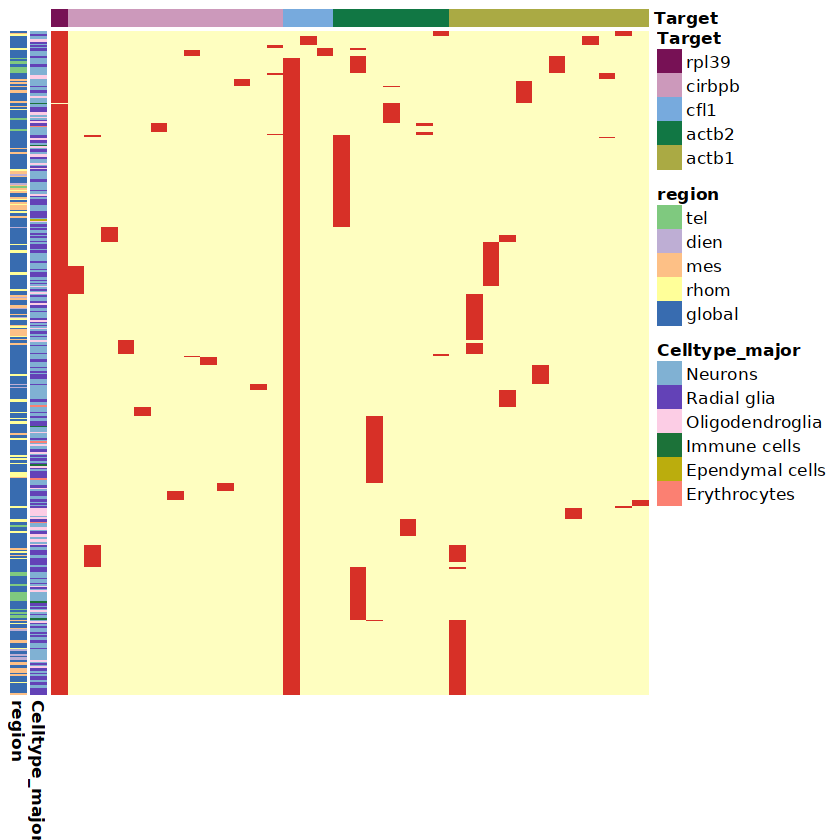

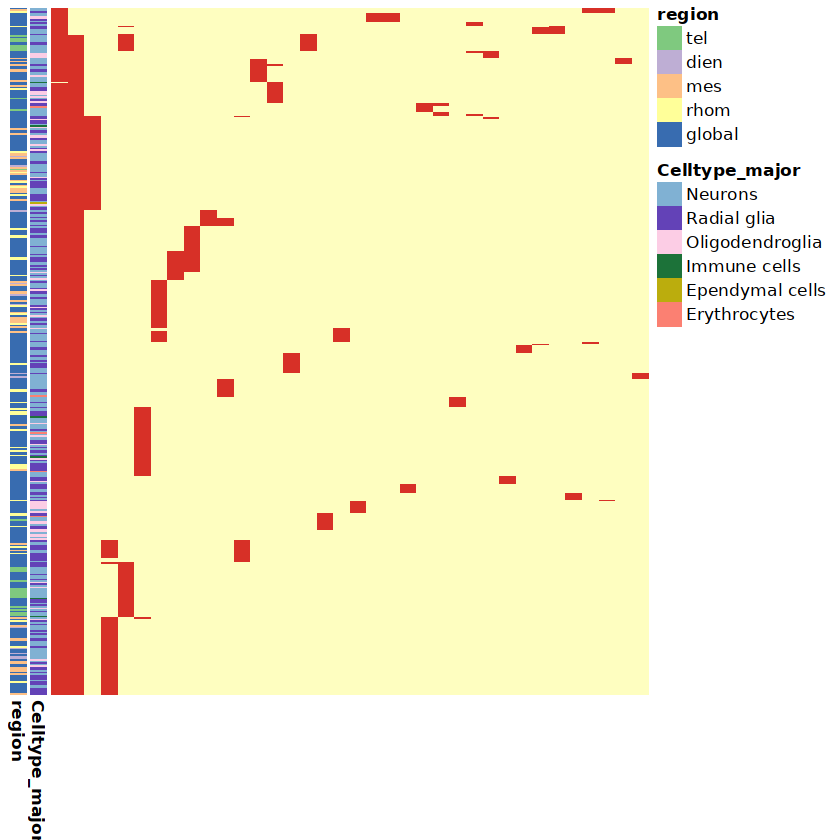

In [21]:
# Make a list of colours to use for cell types, regions and clone-IDs

cols_celltype <- mct_colors[names(mct_colors) %in% cell_info$Celltype_major]

cols_region <- reg_colors[names(reg_colors) %in% cell_info$region]

cols_scar <- tol21rainbow[1:length(unique(scar_info$Clone_ID))]
names(cols_scar) <- unique(scar_info$Clone_ID)

cols_target <- tol21rainbow[c(1,3,6,10,14,16,17)][1:length(unique(scar_info_targ$Target))]
names(cols_target) <- unique(scar_info_targ$Target)

cols_scar <- tol21rainbow[1:length(unique(scar_info_scar$Clone_ID))]
names(cols_scar) <- unique(scar_info_scar$Clone_ID)

ann_colors = list(
    Celltype_major = cols_celltype,
    Clone_ID = cols_scar,
    region = cols_region,
    Target = cols_target    
)

# Plot
ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  breaks = seq(-1, +1, length = 101),
  annotation_row = cell_info[,c("Celltype_major","region")],
  annotation_col = scar_info_targ, # Use this line to add a legend for the cloneIDs
  annotation_colors = ann_colors,
  legend = F,
  treeheight_row = 0,
  treeheight_col = 0,
  cluster_cols = F # Set to true to cluster columns

)

# Plot
ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  breaks = seq(-1, +1, length = 101),
  annotation_row = cell_info[,c("Celltype_major","region")],
  #annotation_col = scar_info_scar, # Use this line to add a legend for the cloneIDs
  annotation_colors = ann_colors,
  legend = F,
  treeheight_row = 0,
  treeheight_col = 0,
  cluster_cols = T # Set to true to cluster columns

)
